In [ ]:
!pip install mediapipe #if you run this script on colab you can install mediapipe by running this cell

Folder structure<br>
<pre>
video-----> <br>
          '1.mp4' <br>
          '2.mp4' <br>
          '3.mp4' <br>
           etc... <br>

audio -----><br>
          '1.wav' <br>
          '2.wav' <br>
          '3.wav' <br>
          etc... <br>
</pre>

Here 1,2,3 are file names. you can name it anything you prefer.but make sure to have the exact same name to the corresponding audio file. All the files should be same fps and same duration.






In [2]:
#@title Main Code - Run this to train the network
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import cv2
from google.colab.patches import cv2_imshow
import mediapipe as mp
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import wavfile
import os
import math
import joblib
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


vid_dir = input('path of video directory - ') #all videos should be same duration
aud_dir = input('path of audio directory - ') #all audio clips should match the video duration and the name.Should be in wav format
BatchSize = int(input('Batch size - '))
hidden_dim = 468
n_layers = 60   #this parameter defines how many rnn layers. research paper suggests 60
length = 150    #This parameter corresponds to duration of the video.Number of frames per single clip. If you have longer clips you can have a igger value
n_epochs = int(input('Epochs - '))
lr=float(input('Learning Rate - '))

vid_ids = [files for files in os.walk(vid_dir)] 
vid_ids = [filenames[:-4] for filenames in vid_ids[0][2] ]

mpDraw = mp.solutions.drawing_utils
mpFaceMesh = mp.solutions.face_mesh
faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)


X_data = []
Y_data = []
Z_data = []
aud = []

for files in vid_ids:
  video = vid_dir +'/'+files+'.mp4'
  audio = aud_dir + '/' + files+'.wav'

  cap = cv2.VideoCapture(video)  #reading the video
  Fs,audio = wavfile.read(audio) #reading the audio
  
  #finding the fps
  (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
  if int(major_ver)  < 3 :
    fps = cap.get(cv2.cv.CV_CAP_PROP_FPS)
    #print ("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
  else :
    fps = cap.get(cv2.CAP_PROP_FPS)
    #print ("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))
  
  #length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  
  
  #creating facepoints
  for i in range(length):
    success,img = cap.read()
    results = faceMesh.process(img)
    
    if results.multi_face_landmarks:
      tempx = []
      tempy = []
      tempz = []
      for faceLms in results.multi_face_landmarks:
        for lm in faceLms.landmark:
          tempx.append(lm.x)
          tempy.append(lm.y)
          tempz.append(lm.z)

    else:
      tempx = []
      tempy = []
      tempz = []
      for i in range(468):
        tempx.append(0)
        tempy.append(0)
        tempz.append(0)
          
    X_data.append(tempx)  
    Y_data.append(tempy)
    Z_data.append(tempz)
      
    
  cap.release()
  
  #creating audio
  
  aud = np.array(np.concatenate((aud, audio.T[0])))
  #print(np.array(audio.T[0]).shape)

#print(np.array(X_data).shape)
time_per_frame_in_video = 1/fps #seconds 1/30
time_per_frame_in_audio = time_per_frame_in_video * Fs
sequences = time_per_frame_in_audio
input_size = int(len(audio)/length)

X_data = torch.tensor(X_data)
Y_data = torch.tensor(Y_data)
Z_data = torch.tensor(Z_data)
aud = torch.tensor(aud)

X_data = X_data.view( -1,BatchSize , length, 468)
Y_data = Y_data.view( -1,BatchSize , length, 468)
Z_data = Z_data.view( -1,BatchSize , length, 468)
aud = aud[0:BatchSize*length*input_size].view(-1,BatchSize,length,input_size)
number_of_batches = aud.size(dim = 0)


class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fcx = nn.Linear(hidden_dim, output_size)
        self.fcy = nn.Linear(hidden_dim, output_size)
        self.fcz = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        #out = out.contiguous().view(-1, self.hidden_dim)
        outX = self.fcx(out)
        outY = self.fcy(out)
        outZ = self.fcz(out)

        return outX, outY, outZ

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden



model = Model(input_size,468,hidden_dim*3,60).to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_vector = []

for epoch in range(n_epochs): # 3 full passes over the data
  #  model.train()
    for data in range(number_of_batches):  # `data` is a batch of data
        model.zero_grad()  # sets gradients to 0 before loss calc. You will do this likely every step.
        outX,outY,outZ = model.forward(aud[data].to(device).float())  # pass in the reshaped batch (recall they are 28x28 atm)
        
        

        lossX = loss_function(outX,X_data[data].to(device).float())
        lossY = loss_function(outY,Y_data[data].to(device).float())
        lossZ = loss_function(outZ,Z_data[data].to(device).float())
        loss = lossX+lossY+lossZ

        loss.backward()  # apply this loss backwards thru the network's parameters
        optimizer.step()  # attempt to optimize weights to account for loss/gradients
    print(epoch,loss)
    loss_vector.append(loss)





path of video directory - /content/drive/MyDrive/Project Docments/lip sync/vid
path of audio directory - /content/drive/MyDrive/Project Docments/lip sync/aud
Batch size - 2
Epochs - 2
Learning Rate - 1
0 tensor(0.3830, grad_fn=<AddBackward0>)
1 tensor(21853.0938, grad_fn=<AddBackward0>)


[0.3829939067363739, 21853.09375]


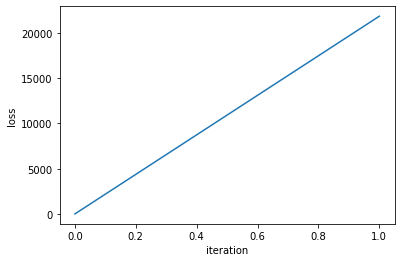

In [3]:
#@title Plot loss
Lv = [] 
for i in range(len(loss_vector)):
    Lv.append(loss_vector[i].item())
print(Lv)
plt.plot(Lv)
plt.xlabel("iteration")
plt.ylabel("loss")

plt.show() 

In [4]:
#@title Save the model (This is optional, If you think you got good results you can save the model for later use)
model.eval()
location = input('Enter the location you would like to save this model/ the model name - ')
#Enter the location you would like to save this model ---> this is the folder you are putting it
#the model name ----> give any name you like
joblib.dump(model, location)


Enter the location you would like to save this model - /content/drive/MyDrive/Project Docments/lip sync/train1


['/content/drive/MyDrive/Project Docments/lip sync/train1']

In [ ]:
#@title You can feed test audio here after training
model.eval()
test = input('audio file path - ')
Fs,test = wavfile.read(test)
l = math.floor(len(test.T[0])/input_size)
test = torch.tensor(test.T[0])[:l*input_size].view(1,l,input_size).to(device)
test_output = model(test.float())